In [93]:
# Alan Raydan
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
import itertools

# Error Estimates for Physics Informed Neural Networks Approximating the Primitive Equations

$$
\begin{align*}
    &u_t + uu_z +wu_z - \nu_h u_{xx} - \nu_z u_{zz} + p_x = 0\\
    &p_z + T = 0\\
    &u_x + w_z = 0\\
    &T_t + uT_x + wT_z - \kappa_h T_{xx} - \kappa T_{zz} = Q
\end{align*}
$$

## Feedforward Neural Network with tanh activation functions
Here we use a standard feedforward network with 2 hidden layers with 128 nodes per layer.

Let me know if you have suggestions for other network architectures/activation functions.

In [94]:
# Feedforward neural network architecture
class PrimitiveNet(nn.Module):
    def __init__(self, spacial_dim, output_dim):
        super().__init__()
        self.spacial_dim = spacial_dim
        self.output_dim = output_dim
        self.net = nn.Sequential(
            nn.Linear(1 + self.spacial_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, self.output_dim))

    def forward(self, t, *x):
        # add assert statement to ensure appropriate dimension of x equals self.spacial_dim
        tx = torch.cat((t, *x), dim=1)
        return self.net(tx)

## Helper functions
Functions to generate the quadrature points for the midpoint rule and the necessary residuals for the primitive equations.

These residuals are taken directly from the overleaf draft, and I try to stick to the notation used in the paper. I can change them if we decide on different residuals in the future.

In [101]:
def generate_quadrature_points(points_per_dimension, min, max):
    """
    Generates an equal number of points in each dimension according to midpoint quadrature method
    where the interval in each dimension is of the form [min, max].
    """
    midpoint_shift = (max - min) / (2 * (points_per_dimension - 1))
    shifted_min = min + midpoint_shift
    shifted_max = max + midpoint_shift
    t = torch.linspace(shifted_min, shifted_max, steps=points_per_dimension)
    x = torch.linspace(shifted_min, shifted_max, steps=points_per_dimension)
    z = torch.linspace(shifted_min, shifted_max, steps=points_per_dimension)
    return t, x, z

def generate_interior_residuals():
    """
    Evaluates needed derivatives for each of the neural nets and returns the PDE
    residuals for the interior of the domain.
    """
    tt, xx, zz = torch.meshgrid(t, x, z, indexing="ij")
    tt = tt.reshape((-1,1)).requires_grad_()
    xx = xx.reshape((-1,1)).requires_grad_()
    zz = zz.reshape((-1,1)).requires_grad_()

    # Forward pass
    u = u_net(tt, xx, zz)
    w = w_net(tt, xx, zz)
    p = p_net(tt, xx, zz)
    T = T_net(tt, xx, zz)

    # create relevant partial derivatives
    u_t = torch.autograd.grad(torch.sum(u), tt, create_graph=True)[0]
    u_x = torch.autograd.grad(torch.sum(u), xx, create_graph=True)[0]
    u_z = torch.autograd.grad(torch.sum(u), zz, create_graph=True)[0]
    u_xx = torch.autograd.grad(torch.sum(u_x), xx, create_graph=True)[0]
    u_zz = torch.autograd.grad(torch.sum(u_z), zz, create_graph=True)[0]
    w_z = torch.autograd.grad(torch.sum(w), zz, create_graph=True)[0]
    p_x = torch.autograd.grad(torch.sum(p), xx, create_graph=True)[0]
    p_z = torch.autograd.grad(torch.sum(p), zz, create_graph=True)[0]
    T_t = torch.autograd.grad(torch.sum(T), tt, create_graph=True)[0]
    T_x = torch.autograd.grad(torch.sum(T), xx, create_graph=True)[0]
    T_z = torch.autograd.grad(torch.sum(T), zz, create_graph=True)[0]
    T_xx = torch.autograd.grad(torch.sum(T_x), xx, create_graph=True)[0]
    T_zz = torch.autograd.grad(torch.sum(T_z), zz, create_graph=True)[0]

    # Evaluate residuals
    R_i_u = u_t + u*u_x + w*u_z - v_h*u_xx - v_z*u_zz + p_x
    R_i_p = p_z + T
    R_i_div = u_x + w_z
    R_i_T = T_t + u*T_x + w*T_z - k_h*T_xx - k_z*T_zz - Q(tt, xx, zz)

    return R_i_u, R_i_p, R_i_div, R_i_T

def generate_boundary_residuals():
    """
    Evaluates needed derivatives for each of the neural nets and returns
    the periodic boundary condition residuals.
    """
    tt, xx = torch.meshgrid(t, z, indexing="ij")
    _, zz = torch.meshgrid(t, x, indexing="ij")
    tt = tt.reshape((-1,1))
    xx = xx.reshape((-1,1))
    zz = zz.reshape((-1,1)).requires_grad_()
    zero = torch.zeros_like(tt, requires_grad=True)
    one = torch.ones_like(tt, requires_grad=True)

    u_boundary_x = (u_net(tt, one, zz) - u_net(tt, zero, zz)).pow(2)
    u_boundary_z = (u_net(tt, xx, one) - u_net(tt, xx, zero)).pow(2)
    u_partial_z_zero = torch.autograd.grad(torch.sum(u_net(tt, xx, zero)), zero, create_graph=True)[0]
    u_partial_z_one = torch.autograd.grad(torch.sum(u_net(tt, xx, one)), one, create_graph=True)[0]
    uR_s_e = torch.sqrt(u_boundary_x + u_boundary_z + u_partial_z_zero.pow(2) + u_partial_z_one.pow(2))

    p_boundary_x = (p_net(tt, one, zz) - p_net(tt, zero, zz)).pow(2)
    p_boundary_z = (p_net(tt, xx, one) - p_net(tt, xx, zero)).pow(2)
    p_partial_z_zero = torch.autograd.grad(torch.sum(p_net(tt, xx, zero)), zero, create_graph=True)[0]
    p_partial_z_one = torch.autograd.grad(torch.sum(p_net(tt, xx, one)), one, create_graph=True)[0]
    pR_s_e = torch.sqrt(p_boundary_x + p_boundary_z + p_partial_z_zero.pow(2) + p_partial_z_one.pow(2))

    w_boundary_x = (w_net(tt, one, zz) - w_net(tt, zero, zz)).pow(2)
    w_boundary_z = w_net(tt, xx, one).pow(2) + w_net(tt, xx, zero).pow(2)
    wR_s_o = torch.sqrt(w_boundary_x + w_boundary_z)

    T_boundary_x = (T_net(tt, one, zz) - T_net(tt, zero, zz)).pow(2)
    T_boundary_z = T_net(tt, xx, one).pow(2) + T_net(tt, xx, zero).pow(2)
    TR_s_o = torch.sqrt(T_boundary_x + T_boundary_z)

    return uR_s_e, wR_s_o, pR_s_e, TR_s_o

def generate_initial_residuals():
    """
    Evaluates the neural nets at initial time and
    returns initial value condition residuals.
    """
    xx, zz = torch.meshgrid(x, z, indexing='ij')
    xx = xx.reshape((-1,1))
    zz = zz.reshape((-1,1))
    zero = torch.zeros_like(xx)
    u_init = u_net(zero, xx, zz)
    true_u_init = -torch.sin(np.pi*xx) * torch.cos(np.pi*zz)
    R_t_u = u_init - true_u_init

    T_init = T_net(zero, xx, zz)
    true_T_init = zero
    R_t_T = T_init - true_T_init

    return R_t_u, R_t_T

## Main learning loop

Here we consider Taylor-Green vortex where $\nu_z = \nu_h = \kappa_z = \kappa_h = 1$ and $Q(t, x, z) = 0$.

The PINN-NSE paper uses 80,000 training epochs, but this would take a long time on my machine. I might try it out anyway but it may not be necessary. The learning rate and number of quadrature points are also taken from the PINN-NSE paper as well as the choice of the midpoint rule for the quadrature.

In [117]:
# Problem parameters
lr = 8e-4
epochs = int(5e3)
spacial_dim = 2
domain_min = 0.0
domain_max = 1.0
num_quad_points = 30
v_z = 1.0
v_h = 1.0
k_z = 1.0
k_h = 1.0
Q = lambda t, x, z: torch.tensor(0.0)

# Initializations
u_net = PrimitiveNet(spacial_dim, 1)
w_net = PrimitiveNet(spacial_dim, 1)
p_net = PrimitiveNet(spacial_dim, 1)
T_net = PrimitiveNet(spacial_dim, 1)
all_params = itertools.chain(u_net.parameters(), w_net.parameters(), p_net.parameters(), T_net.parameters())
optimizer = Adam(all_params, lr)
t, x, z = generate_quadrature_points(num_quad_points, domain_min, domain_max)
errors = []

# Main training loop
for i in range(epochs):

    R_i_u, R_i_p, R_i_div, R_i_T = generate_interior_residuals()
    uR_s_e, wR_s_o, pR_s_e, TR_s_o = generate_boundary_residuals()
    R_t_u, R_t_T = generate_initial_residuals()

    E_i = torch.sum(R_i_u.pow(2) + R_i_p.pow(2) + R_i_div.pow(2) + R_i_T.pow(2)) / num_quad_points**3
    E_s = torch.sum(uR_s_e.pow(2) + wR_s_o.pow(2) + pR_s_e.pow(2) + TR_s_o.pow(2)) / num_quad_points**2
    E_t = torch.sum(R_t_u.pow(2) + R_t_T.pow(2)) / num_quad_points**2
    training_error = E_i + E_s + E_t

    training_error.backward()
    optimizer.step()
    optimizer.zero_grad()

    errors.append(training_error.detach())

Training error looks okay after only 5000 epochs but might benefit from more.

Training error at final epoch: 0.035142138600349426


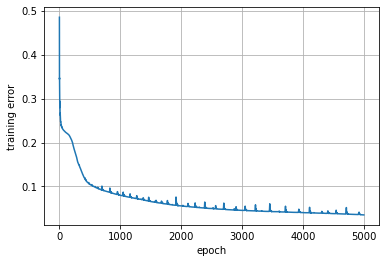

In [125]:
plt.plot(errors)
plt.xlabel("epoch")
plt.ylabel("training error")
#plt.yscale("log")
plt.grid()

print(f"Training error at final epoch: {errors[-1]}")

## Currently working on plotting the trained networks to compare with benchmark solutions